In [42]:
def norm(values): 
    if not type(values) == np.ndarray:
        return normalize(values.numpy().reshape(1,-1))[0]
    else: 
        return normalize(values.reshape(1,-1))[0]

In [52]:
from utils.explanations import calculate_cam_attributions

#cam_attributions = calculate_cam_attributions(root_dir, archive, f"{model}_{itr}", dataset, 'original',  experiment=1, scale='normalized')
gradcam_attributions = calculate_gradcam_attributions(root_dir, archive, f"{model}_{itr}", dataset, 'original',  experiment=1, scale='normalized')
#ig_attributions = calculate_ig_attributions(root_dir, archive, f"{model}_{itr}", dataset, 'original',  task=0, experiment=1, scale='normalized')

input_1
shared_l1
shared_l2
shared_l3
shared_l4
shared_l5
shared_l6
shared_l9
shared_l7
shared_l10
shared_l8
add
shared_l11
shared_l12
shared_l13
shared_l15
shared_l16
shared_l17
shared_l18
shared_l21
shared_l19
shared_l22
shared_20
add_1
shared_l23
shared_l24
shared_l25
shared_l26
shared_l27
shared_l28
shared_l29
shared_l30
shared_l32
shared_l31
add_2
shared_l33
global_average_pooling1d
task_1_output
1
tf.Tensor(
[[0.         0.25761837 0.         0.0415535  0.         0.
  0.         0.2174496  0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.31318408
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.01228133 0.         0.1579966  0.         0.         0.59677374
  0.         0.70896935 0.         1.3501889  0.         1.6064312
  0.         0.6019799  0.         0.         0.         0.
  2.3020837  0.06741393 0.6636719  0.         0.         2.982298
  1.2349541  

In [51]:
from utils.constants import CAM_LAYERS
from utils.explanations import get_layer_index
def calculate_gradcam_attributions(root_dir, archive_name, classifier, dataset_name, data_source, experiment=1, scale='None'):

    #load original data 
    datasets_dict = read_dataset(root_dir, archive_name, dataset_name, 'original', 1)
    x_train, y_train, x_test, y_test = datasets_dict[dataset_name]

    # transform to binary labels
    enc = sklearn.preprocessing.OneHotEncoder()
    enc.fit(np.concatenate((y_train, y_test), axis=0).reshape(-1, 1))
    y_train_binary = enc.transform(y_train.reshape(-1, 1)).toarray()
    
    orgx_train = x_train
    orgx_test = x_test
    
    x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
    x_test  = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)
    
    model_path = f'{root_dir}/results/{archive_name}/{dataset_name}/' \
                    f'/experiment_{experiment}/{classifier.split("_")[:-1][0]}/'\
                    f'{classifier}/{data_source}/best_model.hdf5'  
    #load model 
    #model_path = f'{root_dir}/results/{archive_name}/{dataset_name}/' \
    #                                    + f'{classifier.split("_")[0]}/{classifier}/{data_source}/' \
    #                                    + f'best_model.hdf5'
    
    model = keras.models.load_model(model_path ,compile=False)

    for layer in model.layers: 
        print(layer.name)
    
    #get gap and output layer
    #print(CAM_LAYERS[classifier.split("_")[0]])

    gap = CAM_LAYERS[classifier.split("_")[0]]["last_conv_layer"]
    gap = get_layer_index(model, gap)
    out = CAM_LAYERS[classifier.split("_")[0]]["task_1"]
    out = get_layer_index(model, out)

    w_k_c = model.layers[out].get_weights()[0]  # weights for each filter k for each class c

    grad_model = tf.keras.models.Model([model.inputs], [model.layers[gap].output,  model.layers[out].output])
    output = []
    # Calculate classwise attribution gap to output
    for orgx_vals,x_vals,y_vals in [[orgx_train,x_train,y_train],[orgx_test,x_test,y_test]]:
        attr = list()

        y_pos = list(np.unique(y_train))

        #conv_out, predicted = new_feed_forward([ts])
        for idx,ts in enumerate(x_vals):
            with tf.GradientTape() as tape:
                [conv_out, predicted] = grad_model([ts]) 
                pred_index = tf.math.argmax(predicted[0])
                tf.print(pred_index)
                class_channel = predicted[:, pred_index]
    
            grads = tape.gradient(tf.convert_to_tensor(class_channel), tf.convert_to_tensor(conv_out))
            #tape.gradient(class_channel, conv_out)
            #tape.gradient(tf.convert_to_tensor(class_channel), tf.convert_to_tensor(conv_out))
            pooled_grads = tf.reduce_mean(grads, axis=(0))
            last_conv_layer_output = conv_out[0]
            print(conv_out[0])
            cas = last_conv_layer_output * pooled_grads

            if scale == 'minmax': 
                cas = cas - np.min(cas) / (np.max(cas) - np.min(cas))
            elif scale == 'normalized':
                cas = norm(cas)
            attr.append([y_vals[idx],orgx_vals[idx],cas])
        output.append(attr)
    return output

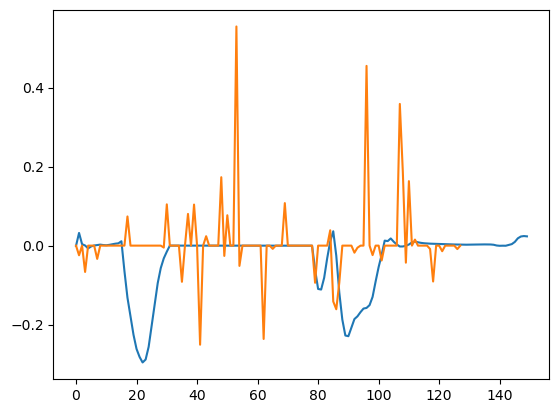

In [53]:
%matplotlib inline
import matplotlib.pyplot as plt
ts = 25

#print(camattributions[0][ts][2])
plt.plot(cam_attributions[0][ts][2])
plt.plot(gradcam_attributions[0][ts][2])
#plt.plot(ig_attributions[0][ts][2])

In [1]:
dataset = 'GunPoint'
model_type = 'resnet'
model = 'resnet'
itr = 0
root_dir = 'G:/Meine Ablage/master thesis/code/xai-tsc'
archive = 'ucr'
dataset_name = 'GunPoint'
archive_name = 'ucr'
task  = 1
data_source = 'original'


import tensorflow_addons as tfa
from utils.explanations import integrated_gradients
from utils.explanations import calculate_gradcam_attributions
from keras.utils import CustomObjectScope
import tensorflow.keras as keras
import tensorflow as tf
import os
from utils.explanations import minmax_norm
from utils.explanations import calculate_ig_attributions
#from utils.explanations import calculate_cam_attributions
from sklearn.metrics import mean_absolute_error, mean_squared_error
from utils.utils import read_dataset
from sklearn.preprocessing import normalize
import numpy as np
import sklearn


ig_link  = f'./results/ucr/{dataset}/experiment_1/{model_type}/{model}_{itr}/{data_source}/best_model.hdf5'
#f'./results/ucr/{dataset}/experiment_1/fcn/fcn_{itr}/original/
#cam_model =keras.models.load_model(cam_link ,compile=False)
ig_model = keras.models.load_model(ig_link ,compile=False)

#Load Dataset
datasets_dict = read_dataset(root_dir, archive_name, dataset_name, 'original', 1)
x_train, y_train, x_test, y_test = datasets_dict[dataset_name]

#Load model 
print(f'./results/ucr/{dataset}/experiment_1/{model_type}/{model}_{itr}/{data_source}/best_model.hdf5')
print(root_dir, archive, f"{model}_{itr}", dataset, f"{model_type}_ig_raw")

cam_attributions = calculate_cam_attributions(root_dir, archive, f"{model}_{itr}", dataset, 'original',  experiment=1, scale='normalized')
gradcam_attributions = calculate_gradcam_attributions(root_dir, archive, f"{model}_{itr}", dataset, 'original',  experiment=1, scale='normalized')

pred_1 = ig_model.predict(x_train)

weights = ig_model.get_weights()
# Set layer to non trainable 

for layer in ig_model.layers:
    if 'shared' in layer.name or 'task_1_output' in layer.name: 
        layer.trainable = False


for i,layer in enumerate(ig_model.layers):
    print(layer.name,  'shared' in layer.name or 'task_1_output' in layer.name)
    if 'shared' in layer.name or 'task_1_output' in layer.name: 
        print(i,layer.name,layer.trainable)



ig_model.compile( 
    optimizer = keras.optimizers.Adam(), 
    loss={'task_1_output': 'categorical_crossentropy','task_2_output': 'mse'},
    loss_weights={'task_1_output': 0, 'task_2_output': 1},
    metrics=['accuracy']) 

ig_model.set_weights(weights)

y_train_2 = []
for e in ig_attributions[0]: 
    y_train_2.append(e[2])
y_train_2 = np.array(y_train_2)
y_val_2 = []
for e in ig_attributions[1]: 
    y_val_2.append(e[2])
y_val_2 = np.array(y_val_2)


enc = sklearn.preprocessing.OneHotEncoder(categories='auto')
enc.fit(np.concatenate((y_train, y_test), axis=0).reshape(-1, 1))
y_train = enc.transform(y_train.reshape(-1, 1)).toarray()


y_test = enc.transform(y_test.reshape(-1, 1)).toarray()

hist = ig_model.fit(
{'input_1': x_train},
{'task_1_output': y_train, 'task_2_output': y_train_2},
batch_size=5, 
epochs= 30,
verbose=False, 
validation_data=(
    x_test,
    {'task_1_output': y_test, 'task_2_output': y_val_2})
)


""" Sanity Check 1: Are predictions the same for classifier"""
pred_2 = ig_model.predict(x_train)

""" Sanity Check 2: Are attributions the same for classifier"""
output = list()
baseline = tf.zeros(len(x_train[0]))

#tf.random.uniform((1,x_train.shape[1]),minval=-1,maxval=1) # tf.zeros(len(x_train[0]))
y_pos = list(np.unique(y_train))
for x_vals,y_vals in [[x_train,y_train],[x_test,y_test]]:
    pred = ig_model.predict(x_vals) if task == 0 else ig_model.predict(x_vals)[0]
    attr = list()
    for idx,ts in enumerate(x_vals):
        series = ts
        ig_att = integrated_gradients(ig_model,baseline,series.astype('float32'),
                                    np.argmax(pred[idx]),
                                    task=task)
                                    #optimize for true values
                                    #y_pos.index(y_vals[idx]),
        attr.append([y_vals[idx],x_vals[idx],ig_att])
    output.append(attr)





c:\Users\boent\anaconda3\envs\xai-tsc\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


./results/ucr/GunPoint/experiment_1/resnet/resnet_0/original/best_model.hdf5
G:/Meine Ablage/master thesis/code/xai-tsc ucr resnet_0 GunPoint resnet_ig_raw


NameError: name 'calculate_cam_attributions' is not defined

In [33]:
len(y_val_2[0])

150

In [8]:

#Load Model
print( f'./results/ucr/{dataset}/experiment_1/{model_type}/{model}_{itr}/{model_type}_ig_raw/last_model.hdf5')
model_link  = f'./results/ucr/{dataset}/experiment_1/{model_type}/{model}_{itr}/{model_type}_ig_raw/last_model.hdf5'
loaded_model = keras.models.load_model(ig_link ,compile=False)


#yvals = 2
ylen = 150

# Existing model
existing_model = loaded_model  # Your existing model

# Select the index of the layer until which you want to freeze


freeze_until_layer_index = 9

# Create a new model with frozen layers
frozen_model = tf.keras.Model(inputs=existing_model.input, outputs=existing_model.layers[freeze_until_layer_index].output)

# Freeze the layers of the frozen_model
for layer in frozen_model.layers:
    layer.trainable = False

# Create new output functions
output_function_1 = tf.keras.layers.GlobalAveragePooling1D()(frozen_model.output)
output_function_1 = tf.keras.layers.Dense(2, activation='softmax', trainable=False, name='task_1_output')(output_function_1)

#Flatten Output Intermediate
flatten = keras.layers.Flatten()(frozen_model.output)
#Conv1D  Output Intermediate
conv1d = keras.layers.Conv1DTranspose(filters=1, kernel_size=3,padding='same',activation="linear")(frozen_model.output)
conv1d_flatten =  keras.layers.Flatten()(conv1d)


def linear_output(): 
    output_function_2 = tf.keras.layers.Dense(ylen, activation='linear', name='task_2_output')(flatten)
    return output_function_2

def tanh_output(): 
    output_function_2 = tf.keras.layers.Dense(ylen, activation='tanh', name='task_2_output')(flatten)
    return output_function_2

def conv1d_output(): 
    output_function_2 =  keras.layers.Conv1DTranspose(filters=1, kernel_size=3,padding='same',activation="linear", name='task_2_output')(frozen_model.output)
    return output_function_2

#Deep Neural Network
def build_deep_nn():
    interm_function_1 = tf.keras.layers.Dense(2*ylen, activation='relu')(conv1d_flatten)
    interm_function_2 = tf.keras.layers.Dense(2*ylen, activation='relu')(interm_function_1)
    interm_function_3 = tf.keras.layers.Dense(2*ylen, activation='relu')(interm_function_2)
    output_function_2 = tf.keras.layers.Dense(ylen, activation='linear', name='task_2_output')(interm_function_3)
    return output_function_2


def build_encoder(): 
    conv4 = keras.layers.Conv1DTranspose(filters=128, kernel_size=3, padding='same')(frozen_model.output)
    conv4 = keras.layers.Activation('relu')(conv4)
    conv5 = keras.layers.Conv1DTranspose(filters=256, kernel_size=5, padding='same')(conv4)
    conv5 = keras.layers.Activation('relu')(conv5)
    conv6 = keras.layers.Conv1DTranspose(filters=128, kernel_size=8, padding='same')(conv5)
    conv6 = keras.layers.Activation('relu')(conv6)
    output_function_2 = keras.layers.Conv1DTranspose(filters=1, kernel_size=3,padding='same',activation="linear",name='task_2_output')(conv6)
    return output_function_2    

#Loop over task specific heads: 
heads = [linear_output, tanh_output, conv1d_output, build_deep_nn, build_encoder]
metric_pd = dict()

for head in heads: 
    
    output_function_2 = head()

    # Create the final model with frozen layers and new output functions
    final_model = tf.keras.Model(inputs=frozen_model.input, outputs=[output_function_1, output_function_2])

    for layer in ig_model.layers:
        if 'shared' in layer.name or 'task_1_output' in layer.name: 
            layer.trainable = False

    final_model.compile( 
        optimizer = keras.optimizers.Adam(), 
        loss={'task_1_output': 'categorical_crossentropy','task_2_output': 'mse'},
        loss_weights={'task_1_output': 0, 'task_2_output': 1},
        metrics=['accuracy']) 

    metric = "loss"
    hist = final_model.fit(
    {'input_1': x_train},
    {'task_1_output': y_train, 'task_2_output': y_train_2},
    batch_size=3, 
    epochs= 50,
    verbose=False, 
    validation_data=(
        x_test,
        {'task_1_output': y_test, 'task_2_output': y_val_2}))

    metric_pd[head.__name__] = {
        "min_mse" : np.min(hist.history['val_' + metric]),
        "min_epo" : int(np.argmin(hist.history['val_' + metric]))
    }



./results/ucr/GunPoint/experiment_1/resnet/resnet_0/resnet_ig_raw/last_model.hdf5


In [9]:
import pandas as pd 
pd.DataFrame(metric_pd)

,linear_output,tanh_output,conv1d_output,build_deep_nn,build_encoder
min_mse,0.180637,0.990085,0.0034,0.00102,0.000591
min_epo,46.000000,32.000000,40.0000,41.00000,46.000000


In [24]:
#GunPoint
import pandas as pd 
pd.DataFrame(metric_pd)

,linear_output,tanh_output,conv1d_output,build_deep_nn,build_encoder
min_mse,0.066763,0.981687,0.004069,0.000863,0.000479
min_epo,8.000000,0.000000,29.000000,46.000000,45.000000


In [39]:
#ECG200
import pandas as pd 
pd.DataFrame(metric_pd)


,linear_output,tanh_output,conv1d_output,build_deep_nn,build_encoder
min_mse,0.241319,0.900695,0.006667,0.001566,0.001198
min_epo,43.000000,0.000000,43.000000,44.000000,31.000000


##  Conv


In [20]:
#GunPoint
import pandas as pd 
pd.DataFrame(metrics)

,linear_output,tanh_output,conv1d_output,build_deep_nn,build_encoder
min_mse,1.633038,0.981747,0.003997,0.001493,0.00007
min_epo,42.000000,23.000000,48.000000,49.000000,48.00000


In [29]:
#ECG200
import pandas as pd 
pd.DataFrame(metrics)

,linear_output,tanh_output,conv1d_output,build_deep_nn,build_encoder
min_mse,0.964756,0.921342,0.005413,0.002079,0.000418
min_epo,31.000000,10.000000,49.000000,45.000000,38.000000


In [17]:
#Beef
import pandas as pd 
pd.DataFrame(metrics)

,linear_output,tanh_output,conv1d_output,build_deep_nn,build_encoder
min_mse,7.662608,0.997608,0.012072,0.001226,0.001171
min_epo,48.000000,0.000000,49.000000,5.000000,2.000000


In [133]:
#final_model.summary()
import matplotlib.pyplot as plt 

In [8]:
metric = "loss"
np.min(hist.history['val_' + metric]), np.argmin(hist.history['val_' + metric])

(0.016434211283922195, 29)

1/1 [==============================] - 0s 402ms/step


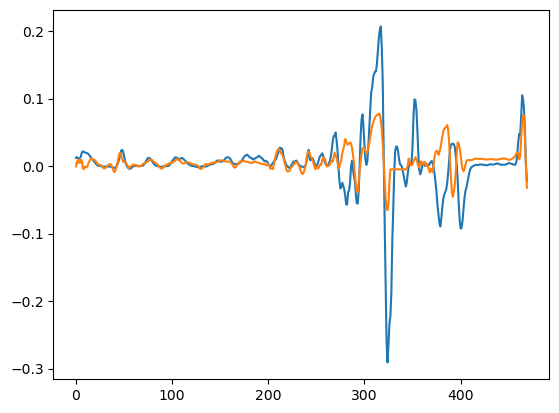

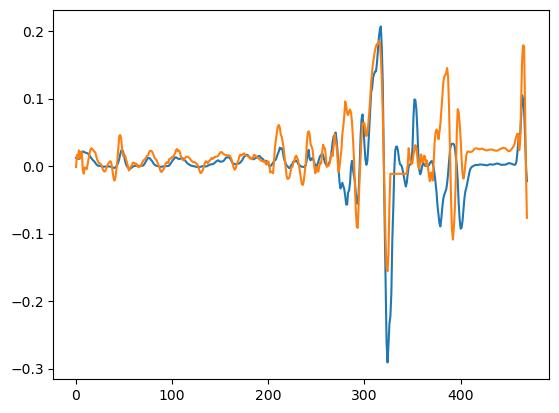

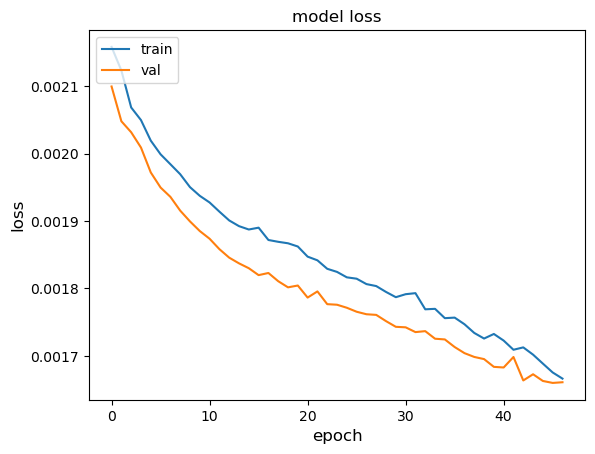

In [48]:
%matplotlib inline
ts = 25

plt.plot(y_val_2[ts])
pr = final_model.predict(x_test)
#print(pr[1][ts])
plt.plot(pr[1][ts])
plt.show()


plt.plot(norm(y_val_2[ts]))
plt.plot(norm(pr[1][ts]))
skip_first_epochs = 3

metric = "loss"
plt.figure()
plt.plot(hist.history[metric][skip_first_epochs:])
plt.plot(hist.history['val_' + metric][skip_first_epochs:])
plt.title('model ' + metric)
plt.ylabel(metric, fontsize='large')
plt.xlabel('epoch', fontsize='large')
plt.legend(['train', 'val'], loc='upper left')

In [75]:
ig_link  = f'./results/ucr/{dataset}/experiment_1/{model_type}/{model}_{itr}/{model_type}_ig_raw/last_model.hdf5'
ig_model = keras.models.load_model(ig_link ,compile=False)


# Existing model
existing_model = ig_model.layers[:9]

existing_model